In [1]:
import datetime

# Third-party
from astropy.io import ascii
import astropy.coordinates as coord
import astropy.units as u
import astropy.time as at
import matplotlib as mpl
import matplotlib.pyplot as pl
import numpy as np
%matplotlib inline

/Users/adrian/anaconda/lib/python2.7/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


In [2]:
import astroplan
from astroplan import Observer, FixedTarget
from astropy.time import Time


>>> from astroplan import download_IERS_A
>>> download_IERS_A()
 [astroplan.utils]

>>> from astroplan import download_IERS_A
>>> download_IERS_A()



In [3]:
mdm = Observer.at_site("MDM", timezone="America/Phoenix")
t1 = Time(datetime.datetime(2016, 3, 14, 18, 0))
t2 = t1 + 12*u.hour
time_range = Time([t1, t2])

In [4]:
def coords_in_rect(c, corner_c):
    if not c.frame.is_equivalent_frame(corner_c[0].frame):
        raise ValueError("Frame mismatch.")
    
    min_lon = corner_c[0].spherical.lon
    min_lat = corner_c[0].spherical.lat
    max_lon = corner_c[1].spherical.lon
    max_lat = corner_c[1].spherical.lat
    
    return ((c.spherical.lon > min_lon) & (c.spherical.lon < max_lon) & 
            (c.spherical.lat > min_lat) & (c.spherical.lat < max_lat)) 

---

## How many GASS targets are there?

In [5]:
css = ascii.read("/Users/adrian/projects/triand-rrlyrae/data/catalina.csv")
print(css.colnames)

['ID', 'ra', 'dec', 'VmagAvg', 'helio_dist', 'l', 'b', 'mjd0', 'amp', 'period']


In [6]:
linear = ascii.read("/Users/adrian/projects/triand-rrlyrae/data/linear.csv")
print(linear.colnames)

['ra', 'dec', 'ID', 'period', 'not_hjd0', 'amp', 'rmagAvg', 'helio_dist', 'l', 'b']


In [7]:
css_c = coord.SkyCoord(ra=css['ra']*u.deg, dec=css['dec']*u.deg, distance=css['helio_dist']*u.kpc)
lin_c = coord.SkyCoord(ra=linear['ra']*u.deg, dec=linear['dec']*u.deg, distance=linear['helio_dist']*u.kpc)

### Filter by window on sky

In [8]:
window_corners = [coord.SkyCoord(l=100*u.deg, b=10*u.deg,frame='galactic'), 
                  coord.SkyCoord(l=260*u.deg, b=30*u.deg,frame='galactic')]
css_ix = coords_in_rect(css_c.galactic, window_corners)
lin_ix = coords_in_rect(lin_c.galactic, window_corners)
print("{} CSS targets, {} LINEAR targets in this window.".format(css_ix.sum(), lin_ix.sum()))

465 CSS targets, 2 LINEAR targets in this window.


In [9]:
gass_tbl = css[css_ix]
gass = coord.SkyCoord(l=gass_tbl['l']*u.deg, b=gass_tbl['b']*u.deg, 
                      distance=gass_tbl['helio_dist']*u.kpc, frame='galactic')

### Filter by distance

In [10]:
ix = (((gass.distance > 1*u.kpc) & (gass.distance < 8.*u.kpc)) |
      ((gass.distance > 7*u.kpc) & (gass.distance < 15.*u.kpc)))
gass = gass[ix]
gass_tbl = gass_tbl[ix]

In [11]:
print("{} GASS targets".format(len(gass)))

231 GASS targets


(0, 30)

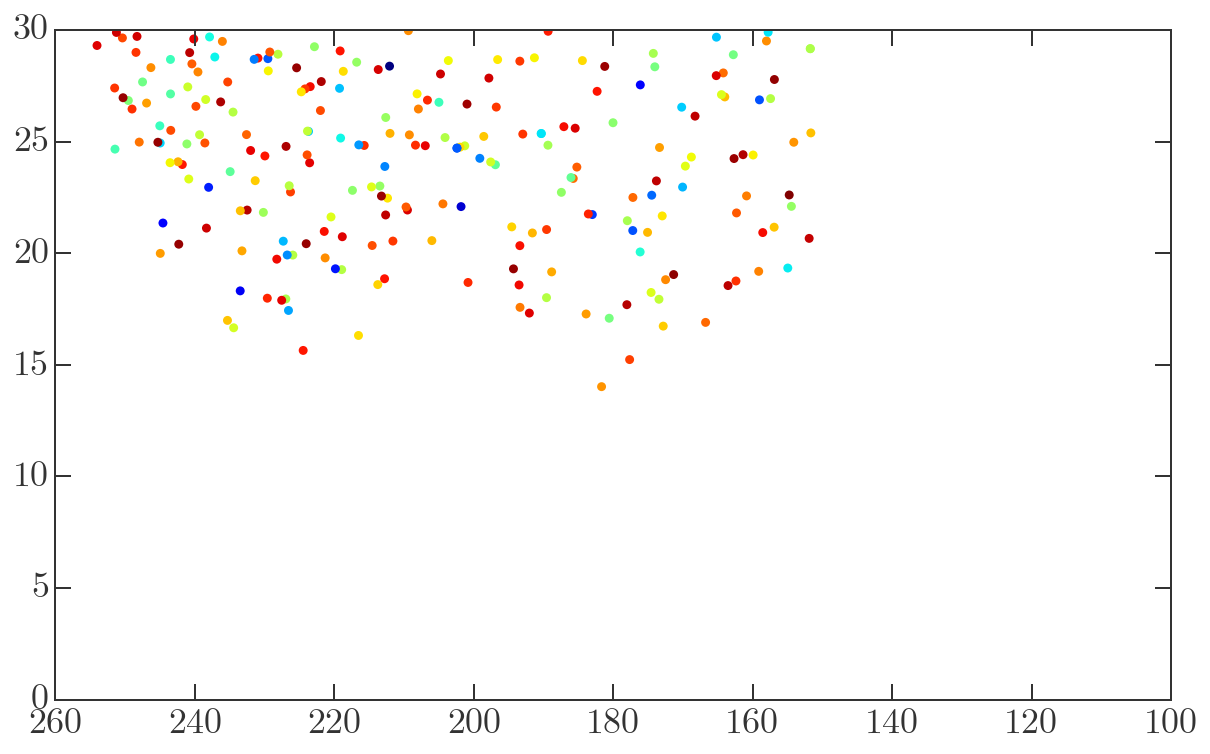

In [14]:
pl.figure(figsize=(10,6))
pl.scatter(gass.l.degree, gass.b.degree, c=gass_tbl['VmagAvg'], marker='o')
pl.xlim(260,100)
pl.ylim(0,30)

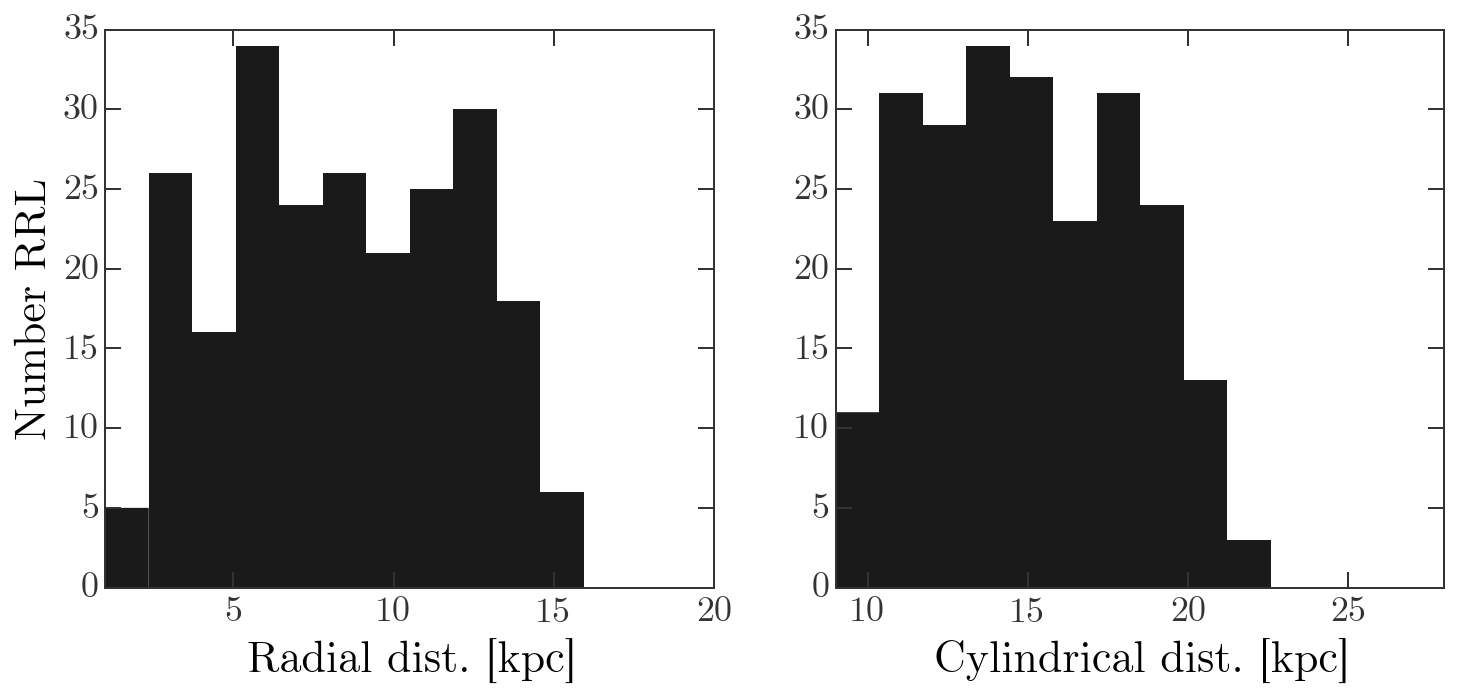

In [16]:
fig,axes = pl.subplots(1,2,figsize=(12,5))
n,bins,pa = axes[0].hist(gass.distance, bins=np.linspace(1,20,15))
axes[0].set_xlabel("Radial dist. [kpc]")
axes[0].set_xlim(bins.min(), bins.max())

n,bins,pa = axes[1].hist(gass.galactocentric.represent_as(coord.CylindricalRepresentation).rho, bins=bins+8)
axes[1].set_xlabel("Cylindrical dist. [kpc]")
axes[1].set_xlim(bins.min(), bins.max())

axes[0].set_ylabel("Number RRL")

### Red circle below is brightness limit of Catalina

<matplotlib.colorbar.Colorbar instance at 0x112fbd440>

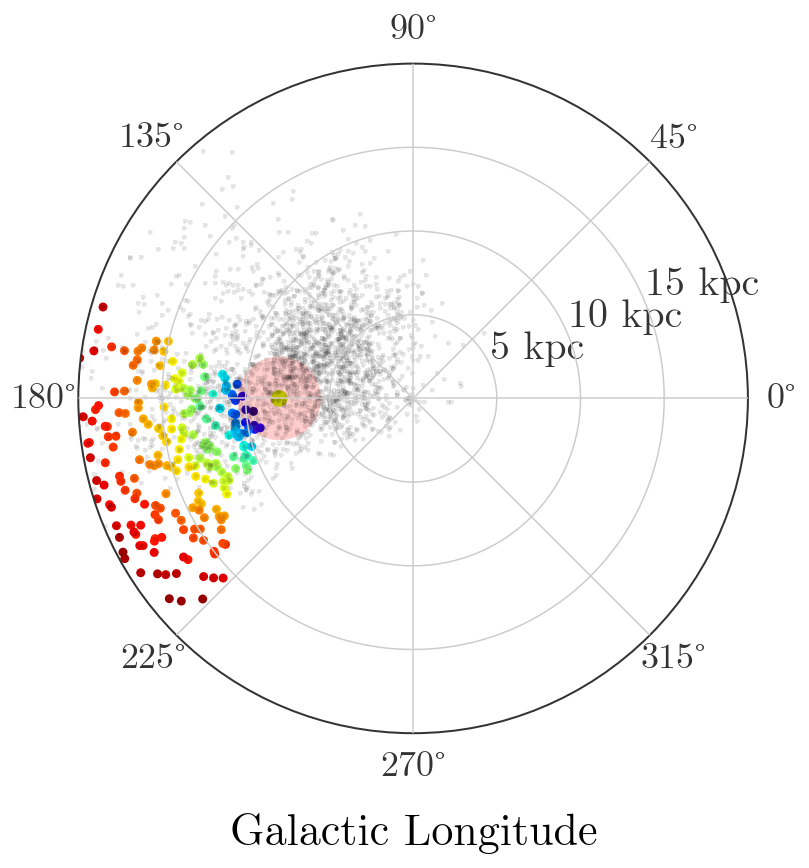

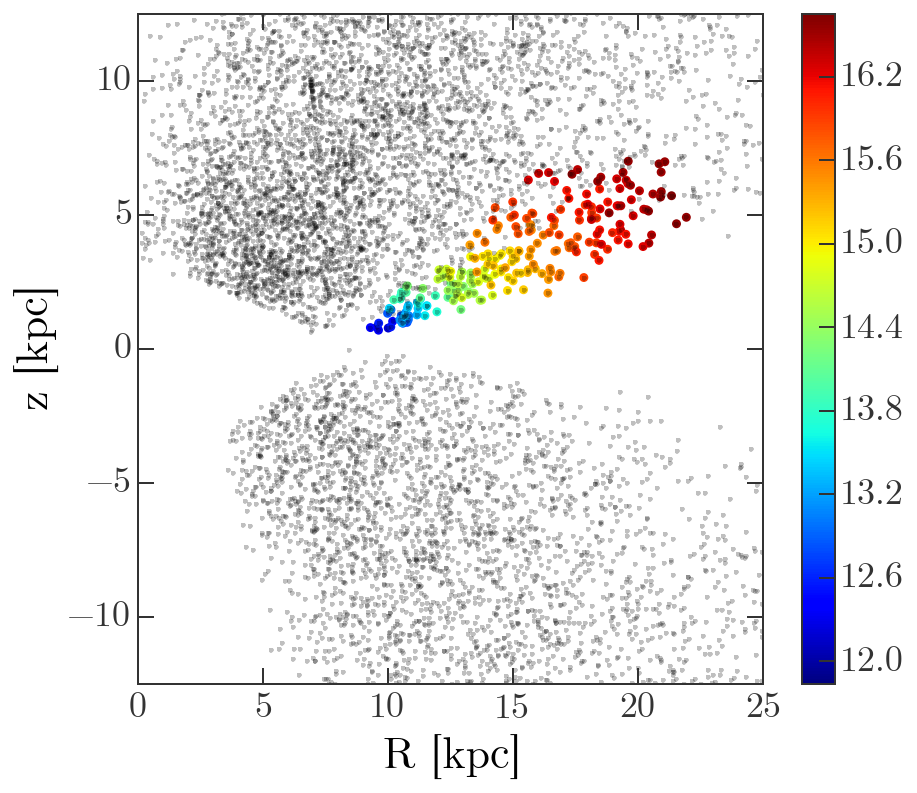

In [50]:
fig,ax = pl.subplots(1,1,figsize=(6,6),subplot_kw =dict(polar=True))

ax.add_artist(mpl.patches.Circle((-8.,0), radius=2.5, transform=ax.transData._b, facecolor='r', alpha=0.2))
ax.add_artist(mpl.patches.Circle((-8.,0), radius=0.5, transform=ax.transData._b, facecolor='y', alpha=1.))

gass_cyl = gass.galactocentric.represent_as(coord.CylindricalRepresentation)
css_cyl = css_c.galactocentric.represent_as(coord.CylindricalRepresentation)

ax.plot(css_cyl.phi.to(u.radian)[np.abs(css_cyl.z) < 5*u.kpc], 
        css_cyl.rho.to(u.kpc)[np.abs(css_cyl.z) < 5*u.kpc], 
        color='k', linestyle='none', marker='.', alpha=0.1)
# ax.plot(gass_cyl.phi.to(u.radian), gass_cyl.rho.to(u.kpc), 
#         color='k', linestyle='none', marker='o')
ax.scatter(gass_cyl.phi.to(u.radian), gass_cyl.rho.to(u.kpc), 
           c=gass_tbl['VmagAvg'], marker='o')

ax.set_rmax(20.0)
ax.grid(True)

ticks = [5,10,15]
ax.set_rticks(ticks)
ax.set_yticklabels(['{0:d} kpc'.format(x) for x in ticks])
ax.set_xlabel("Galactic Longitude", labelpad=15)
ax.tick_params(axis='y', labelsize=20)
# fig.savefig("/Users/adrian/papers/proposals/MDM-2015/GASS.pdf")

# ------
fig,ax = pl.subplots(1,1,figsize=(7,6))

gass_cyl = gass.galactocentric.represent_as(coord.CylindricalRepresentation)
css_cyl = css_c.galactocentric.represent_as(coord.CylindricalRepresentation)

ax.plot(css_cyl.rho.to(u.kpc), 
        css_cyl.z.to(u.kpc), 
        color='k', linestyle='none', marker='.', alpha=0.25)
cc = ax.scatter(gass_cyl.rho.to(u.kpc), 
                gass_cyl.z.to(u.kpc), 
                c=gass_tbl['VmagAvg'], marker='o')
ax.set_xlim(0,25)
ax.set_ylim(-12.5,12.5)
ax.set_xlabel("R [kpc]")
ax.set_ylabel("z [kpc]")
fig.colorbar(cc)

# ticks = [10,20]
# ax.set_rticks(ticks)
# ax.set_yticklabels(['{0:d} kpc'.format(x) for x in ticks])
# ax.set_xlabel("Galactic Longitude", labelpad=15)
# ax.tick_params(axis='y', labelsize=20)
# # fig.savefig("/Users/adrian/papers/proposals/MDM-2015/GASS.pdf")

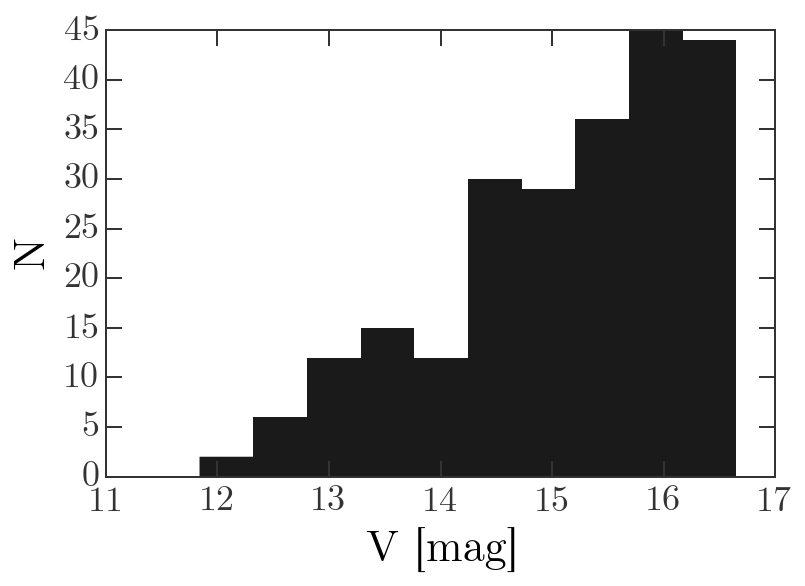

In [43]:
pl.hist(gass_tbl['VmagAvg'])
pl.xlabel("V [mag]")
pl.ylabel("N")

In [32]:
# gass_tbl['ID2015'] = ["GASS2015RR{0:d}".format(x+1) for x in np.arange(len(gass_tbl)).astype(int)]

In [33]:
# ascii.write(gass_tbl, "/Users/adrian/projects/triand-rrlyrae/data/targets/gass.txt")

In [19]:
# ascii.write(gass_tbl[['ID2015','ra','dec']], "/Users/adrian/projects/triand-rrlyrae/data/targets/gass_targets_2015_short.txt")#, format="ascii")

In [20]:
# gass_tbl_sex = gass_tbl.copy()

# ra = coord.Longitude(gass_tbl_sex['ra']*u.deg)
# gass_tbl_sex['ra_sex'] = ra.to_string(unit=u.hour, precision=5, sep=':')

# dec = coord.Latitude(gass_tbl_sex['dec']*u.deg)
# gass_tbl_sex['dec_sex'] = dec.to_string(unit=u.degree, precision=5, sep=':')

# ascii.write(gass_tbl_sex[['ID2015','ra_sex','dec_sex']], "/Users/adrian/projects/triand-rrlyrae/data/targets/gass_targets_2015_short_sexa.txt")

---

## A13 selection

In [21]:
window_corners = [coord.SkyCoord(l=120.*u.deg, b=25.*u.deg,frame='galactic'), 
                  coord.SkyCoord(l=180*u.deg, b=35*u.deg,frame='galactic')]
css_ix2 = coords_in_rect(css_c.galactic, window_corners)
print("{} CSS targets in this window.".format(css_ix2.sum()))

85 CSS targets in this window.


In [27]:
a13_tbl = css[css_ix2]
a13 = coord.SkyCoord(l=a13_tbl['l']*u.deg, b=a13_tbl['b']*u.deg, 
                     distance=a13_tbl['helio_dist']*u.kpc, frame='galactic')

### Filter distance

In [28]:
ix = (a13.distance > 10*u.kpc) & (a13.distance < 35*u.kpc)
a13 = a13[ix]
a13_tbl = a13_tbl[ix]

In [29]:
print("{} A13 targets".format(len(a13)))

42 A13 targets


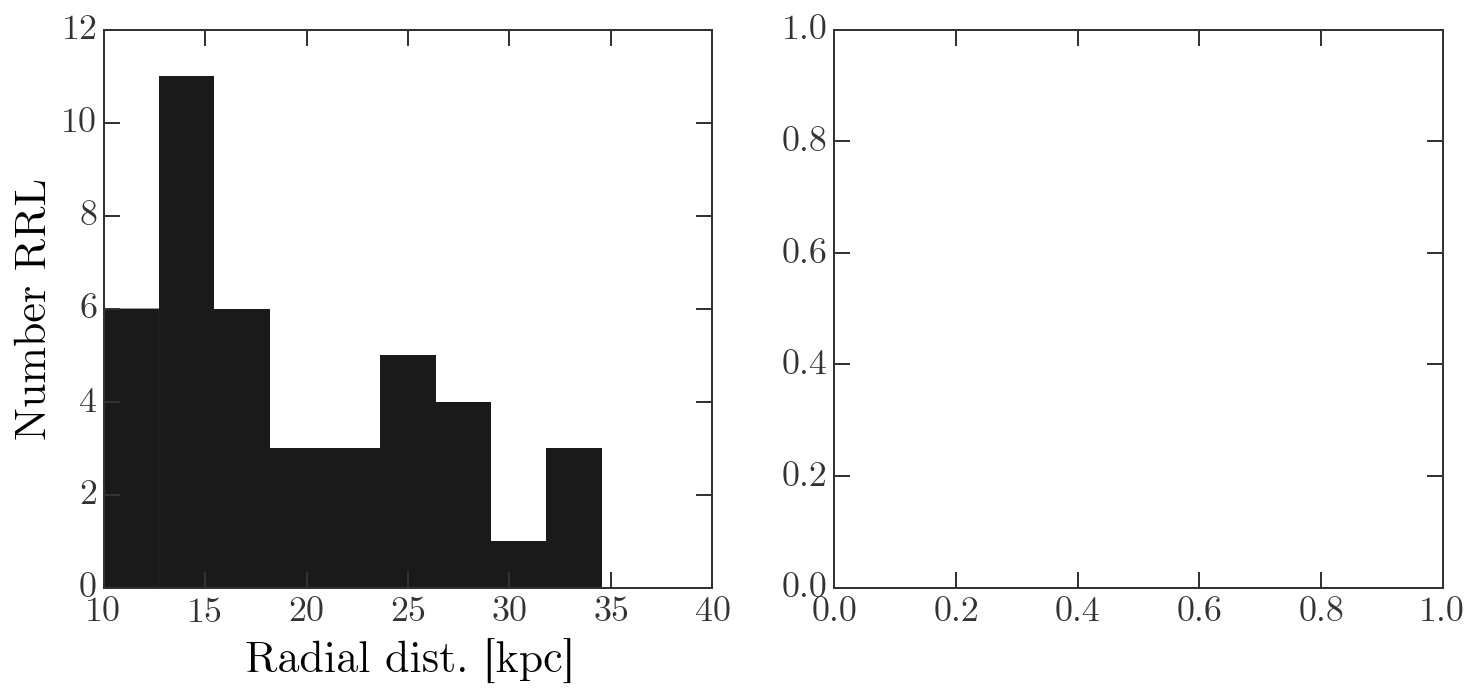

In [32]:
fig,axes = pl.subplots(1,2,figsize=(12,5))
n,bins,pa = axes[0].hist(a13_tbl['helio_dist'], bins=np.linspace(10,40,12))
axes[0].set_xlabel("Radial dist. [kpc]")
axes[0].set_xlim(bins.min(),bins.max())

# axes[1].hist(gc_cyl_triand.rho, bins=8)
# axes[1].set_xlabel("Cylindrical dist. [kpc]")
# axes[1].set_xlim(17,24)

axes[0].set_ylabel("Number RRL")

<matplotlib.colorbar.Colorbar instance at 0x110ac7710>

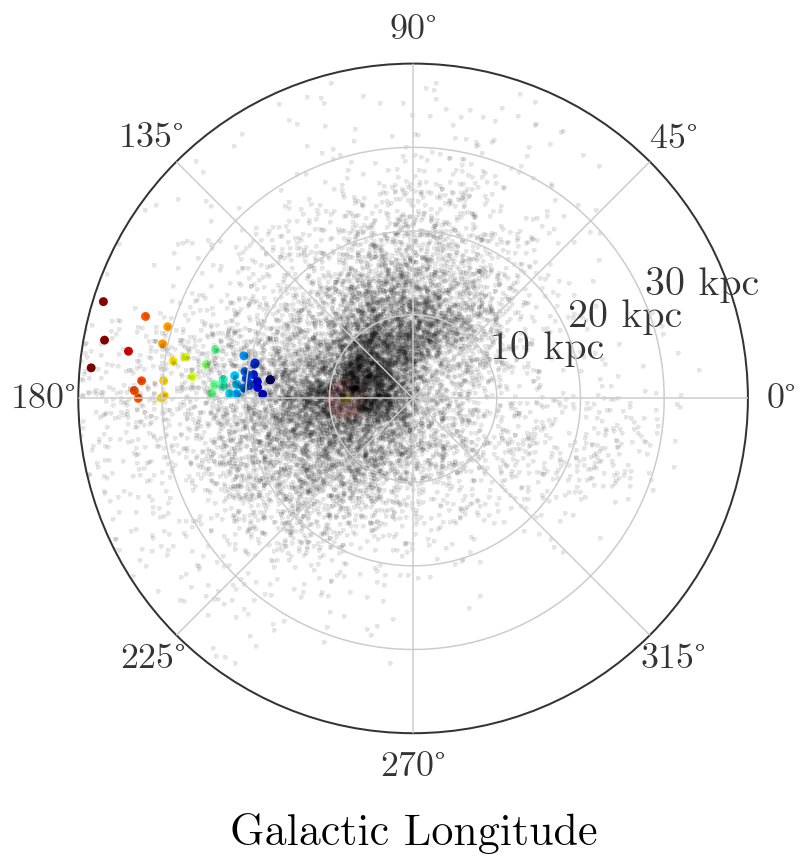

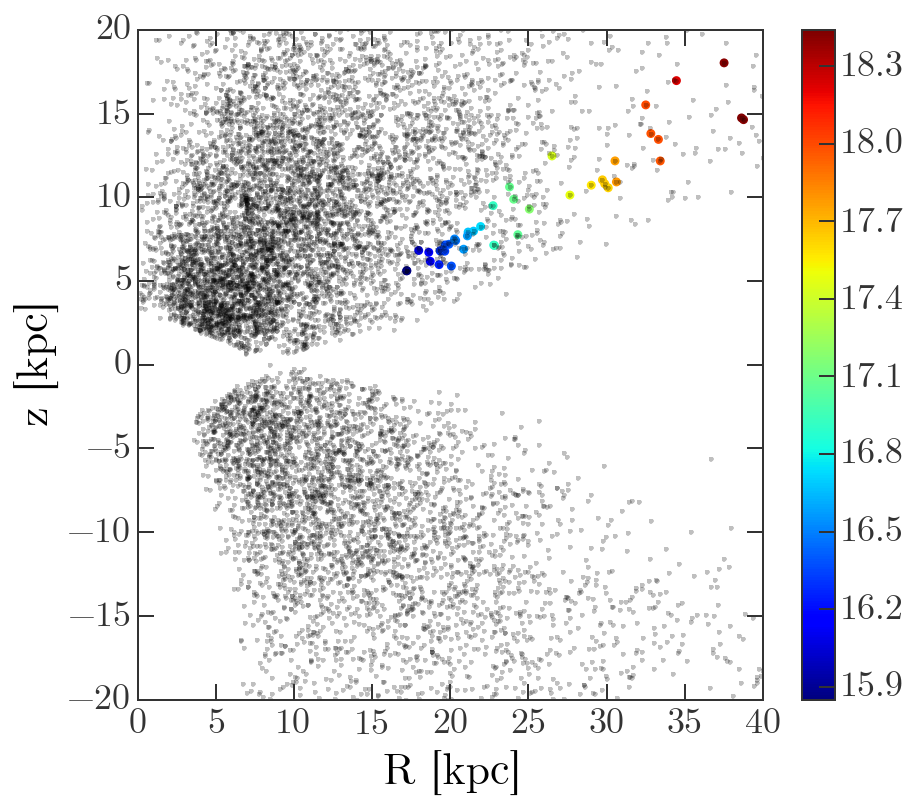

In [48]:
fig,ax = pl.subplots(1,1,figsize=(6,6),subplot_kw =dict(polar=True))

ax.add_artist(mpl.patches.Circle((-8.,0), radius=2.5, transform=ax.transData._b, facecolor='r', alpha=0.2))
ax.add_artist(mpl.patches.Circle((-8.,0), radius=0.5, transform=ax.transData._b, facecolor='y', alpha=1.))

a13_cyl = a13.galactocentric.represent_as(coord.CylindricalRepresentation)
css_cyl = css_c.galactocentric.represent_as(coord.CylindricalRepresentation)

ax.plot(css_cyl.phi.to(u.radian), 
        css_cyl.rho.to(u.kpc), 
        color='k', linestyle='none', marker='.', alpha=0.1)
# ax.plot(gass_cyl.phi.to(u.radian), gass_cyl.rho.to(u.kpc), 
#         color='k', linestyle='none', marker='o')
ax.scatter(a13_cyl.phi.to(u.radian), a13_cyl.rho.to(u.kpc), 
           c=a13_tbl['VmagAvg'], marker='o')

ax.set_rmax(40.0)
ax.grid(True)

ticks = [10,20,30]
ax.set_rticks(ticks)
ax.set_yticklabels(['{0:d} kpc'.format(x) for x in ticks])
ax.set_xlabel("Galactic Longitude", labelpad=15)
ax.tick_params(axis='y', labelsize=20)
# fig.savefig("/Users/adrian/papers/proposals/MDM-2015/GASS.pdf")

# ------
fig,ax = pl.subplots(1,1,figsize=(7,6))

ax.plot(css_cyl.rho.to(u.kpc), 
        css_cyl.z.to(u.kpc), 
        color='k', linestyle='none', marker='.', alpha=0.25)
cc = ax.scatter(a13_cyl.rho.to(u.kpc), 
                a13_cyl.z.to(u.kpc), 
                c=a13_tbl['VmagAvg'], marker='o')
ax.set_xlim(0,40)
ax.set_ylim(-20.,20)
ax.set_xlabel("R [kpc]")
ax.set_ylabel("z [kpc]")
fig.colorbar(cc)

# ticks = [10,20]
# ax.set_rticks(ticks)
# ax.set_yticklabels(['{0:d} kpc'.format(x) for x in ticks])
# ax.set_xlabel("Galactic Longitude", labelpad=15)
# ax.tick_params(axis='y', labelsize=20)
# # fig.savefig("/Users/adrian/papers/proposals/MDM-2015/GASS.pdf")

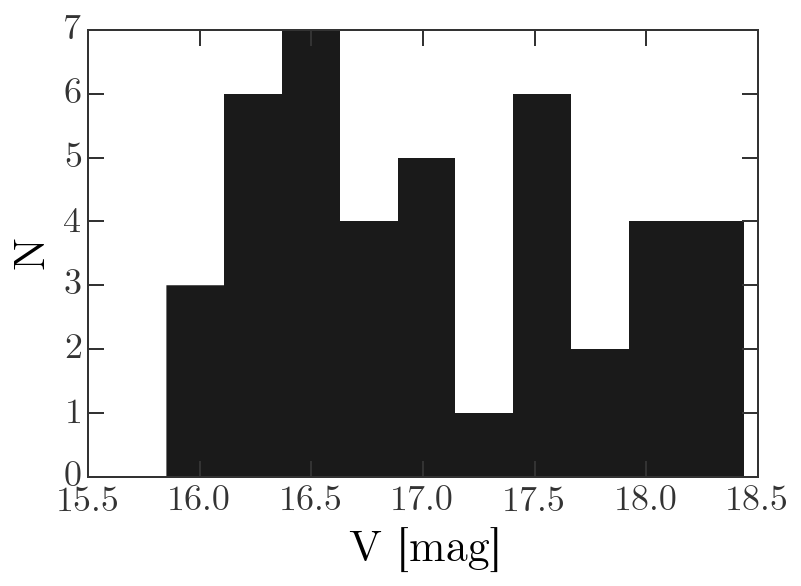

In [51]:
pl.hist(a13_tbl['VmagAvg'])
pl.xlabel("V [mag]")
pl.ylabel("N")

In [39]:
# fig,ax = pl.subplots(1,1,figsize=(8,8),subplot_kw =dict(polar=True))

# ax.add_artist(mpl.patches.Circle((-8.,0), radius=0.5, transform=ax.transData._b, facecolor='y', alpha=1.))

# ax.plot(all_gc_cyl.phi.to(u.radian)[sky_window], all_gc_cyl.rho.to(u.kpc)[sky_window], 
#         color='k', linestyle='none', marker='o', alpha=0.25)

# ax.plot(gc_cyl_triand.phi.to(u.radian), gc_cyl_triand.rho.to(u.kpc), 
#         color='k', linestyle='none', marker='o')
# ax.set_rmax(30.0)
# ax.grid(True)

In [46]:
# ascii.write(triand_tbl, "/Users/adrian/projects/triand-rrlyrae/data/targets/triand1_targets_2015.txt")#, format="ascii")

In [51]:
# ascii.write(triand_tbl[triand_tbl['ID2013']=='--'][['ID2015','ra','dec']], "/Users/adrian/projects/triand-rrlyrae/data/targets/triand1_targets_2015_short.txt")#, format="ascii")

In [33]:
# triand_tbl_sex = triand_tbl.copy()

# ra = coord.Longitude(triand_tbl_sex['ra']*u.deg)
# triand_tbl_sex['ra_sex'] = ra.to_string(unit=u.hour, precision=5, sep=':')

# dec = coord.Latitude(triand_tbl_sex['dec']*u.deg)
# triand_tbl_sex['dec_sex'] = dec.to_string(unit=u.degree, precision=5, sep=':')

# ascii.write(triand_tbl_sex[triand_tbl['ID2013']=='--'][['ID2015','ra_sex','dec_sex']], "/Users/adrian/projects/triand-rrlyrae/data/targets/triand1_targets_2015_short_sexa.txt")

---

### Brightness limit of Catalina

Claim is that it is V ~ 12.5

In [34]:
from gary.observation import distance, apparent_magnitude
from gary.observation.rrlyrae import M_V

In [35]:
distance(12.5 - M_V(-1.5)).to(u.kpc)

<Quantity 2.570395782768865 kpc>

In [36]:
apparent_magnitude(M_V(-1.5), 10.*u.kpc)

15.449999999999999

---

### Exposure times

In [37]:
from scipy.interpolate import InterpolatedUnivariateSpline

(14, 18)

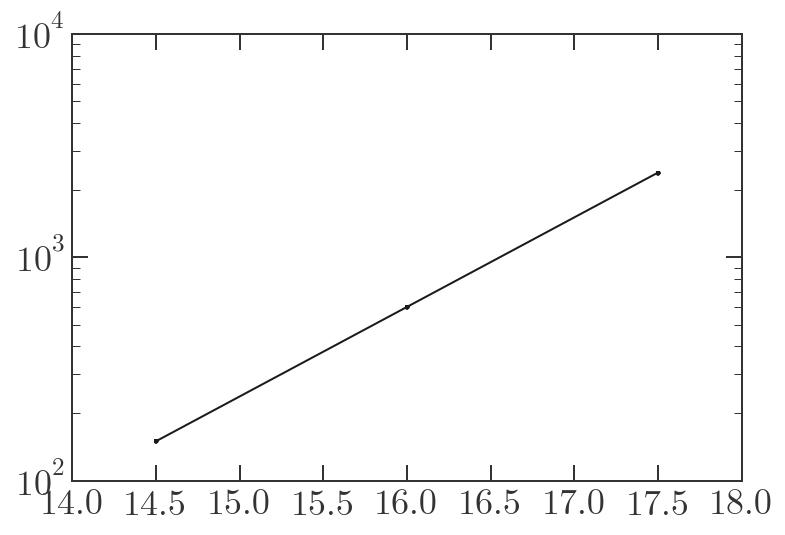

In [38]:
pl.semilogy([14.5,16,17.5], [150,600,2400])
pl.xlim(14, 18)

In [39]:
def Vmag_to_exptime(V):
    s = InterpolatedUnivariateSpline([14.5,16,17.5], np.log10([150,600,2400]), k=1)
    y = 10**s(V)
    return y

In [40]:
a13_exptimes = [Vmag_to_exptime(V) for V in a13_tbl['VmagAvg']]
GASS_exptimes = [Vmag_to_exptime(V) for V in gass_tbl['VmagAvg']]

In [41]:
len(a13_exptimes), len(GASS_exptimes)

(42, 231)

In [42]:
print("A13", (sum(a13_exptimes)*u.second).to(u.hour))
print("GASS", (sum(GASS_exptimes)*u.second).to(u.hour))

('A13', <Quantity 23.65079402950761 h>)
('GASS', <Quantity 25.294328651449682 h>)
